In [1]:
import warnings
warnings.filterwarnings('ignore')

# Matplotlib inline magic command
%matplotlib inline

In [2]:
# Initial imports
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
from collections import Counter
import psycopg2
from config import db_password
import json
from pandas.io.json import json_normalize
import mysql.connector
from sqlalchemy import create_engine
from os import walk
import time
from pprint import pprint

In [73]:
# Scikit-Learn dependencies
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import plot_confusion_matrix

In [4]:
# Connect to AWS
def getDBengine1():
    user = 'postgres'
    passw = db_password
    host = 'policekillings.cv95lgysyvwq.us-east-1.rds.amazonaws.com'
    port = 5432
    database = 'PoliceKillings'
    engine_1 = create_engine(f'postgres+psycopg2://' + user + ':' + passw + '@' + host + ':' + str(port) + '/' + database ,  echo=False)
    return engine_1

In [5]:
# Load database into DataFrame
def getData1():
    s_statement = "select * from public.police_killings"
    # df = pd.read_sql(s_statement, con=getDBengine())
    try:
        df = pd.read_sql(s_statement, con=getDBengine1())
    except:
        print('failed')
    return df

In [6]:
killings_df = getData1()
killings_df.shape
print(killings_df.columns)

Index(['Victim_Age', 'Victim_Gender', 'Victim_Race', 'Date', 'City', 'State',
       'County', 'Responsible_Agency', 'Cause_of_death', 'Brief_Description ',
       'Criminal_Charges', 'Mental_Illness', 'Armed_Status', 'Threat_Level ',
       'Fleeing ', 'Body_Camera', 'Geography', 'Encounter_Type ',
       'Initial_Reason_for_Encounter ', 'Call_for_Service'],
      dtype='object')


In [7]:
# Load the data
file_path = 'Resources/2013-2020_Police_Killings_Revised.xlsx' 
killings_df = pd.read_excel(file_path)                         
killings_df

,Victim's age,Victim's gender,Victim's race,Date of Incident (month/day/year),County,Agency responsible for death,Cause of death,Symptoms of mental illness?,Armed/Unarmed Status,Alleged Threat Level (Source: WaPo),Fleeing (Source: WaPo),Body Camera (Source: WaPo),Geography,Encounter Type (DRAFT),Initial Reported Reason for Encounter (DRAFT),Call for Service? (DRAFT)
0,Unknown,Male,Unknown Race,2021-04-18,NaN,Detroit Police Department,Gunshot,NaN,Allegedly Armed,attack,NaN,NaN,NaN,Part 1 Violent Crime,shooting,NaN
1,Unknown,Male,Unknown Race,2021-04-18,NaN,Douglasville Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unknown,Male,Unknown Race,2021-04-18,NaN,Fort Worth Police Department,Gunshot,NaN,Allegedly Armed,NaN,NaN,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
3,Unknown,Male,White,2021-04-18,NaN,Burnsville Police Department,Gunshot,NaN,Allegedly Armed,attack,car,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
4,Unknown,Male,Black,2021-04-17,NaN,Winter Haven Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,Domestic disturbance,Domestic disturbance (armed),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9077,21,Male,White,2013-01-01,Douglas,Douglas County Sheriff's Office,Gunshot,Drug or alcohol use,Allegedly Armed,NaN,NaN,NaN,Rural,NaN,NaN,NaN
9078,26,Male,White,2013-01-01,Blue Earth,Mankato Department of Public Safety,Taser,No,Unarmed/Did Not Have Actual Weapon,NaN,NaN,NaN,Suburban,NaN,NaN,NaN
9079,21,Male,Hispanic,2013-01-01,Pueblo,Pueblo Police Department,Gunshot,No,Allegedly Armed,NaN,NaN,NaN,Suburban,NaN,NaN,NaN
9080,49,Male,Hispanic,2013-01-01,San Juan,Farmington Police Department,Gunshot,No,Allegedly Armed,NaN,NaN,NaN,Urban,NaN,NaN,NaN


In [8]:
# Rename columns
killings_df.rename(columns = {"Victim's age" : 'Victim_Age', "Victim's gender" : 'Victim_Gender', 
                              "Victim's race" : 'Victim_Race', 'Date of Incident (month/day/year)' : 'Date',
                              'Agency responsible for death' : 'Responsible_Agency', 'Cause of death' : 'Cause_of_Death',
                              'A brief description of the circumstances surrounding the death' : 'Brief_Description',
                              'Criminal Charges?' : 'Criminal_Charges', 'Symptoms of mental illness?' : 'Mental_Illness', 
                              'Armed/Unarmed Status' : 'Armed_Status', 'Alleged Threat Level (Source: WaPo)' : 'Threat_Level', 
                              'Fleeing (Source: WaPo)' : 'Fleeing', 'Body Camera (Source: WaPo)' : 'Body_Camera', 
                              'Encounter Type (DRAFT)' : 'Encounter_Type', 
                              'Initial Reported Reason for Encounter (DRAFT)' : 'Initial_Reason_for_Encounter',
                              'Call for Service? (DRAFT)' : 'Call_for_Service'}, inplace = True)

killings_df.head()

,Victim_Age,Victim_Gender,Victim_Race,Date,County,Responsible_Agency,Cause_of_Death,Mental_Illness,Armed_Status,Threat_Level,Fleeing,Body_Camera,Geography,Encounter_Type,Initial_Reason_for_Encounter,Call_for_Service
0,Unknown,Male,Unknown Race,2021-04-18,NaN,Detroit Police Department,Gunshot,NaN,Allegedly Armed,attack,NaN,NaN,NaN,Part 1 Violent Crime,shooting,NaN
1,Unknown,Male,Unknown Race,2021-04-18,NaN,Douglasville Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unknown,Male,Unknown Race,2021-04-18,NaN,Fort Worth Police Department,Gunshot,NaN,Allegedly Armed,NaN,NaN,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
3,Unknown,Male,White,2021-04-18,NaN,Burnsville Police Department,Gunshot,NaN,Allegedly Armed,attack,car,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
4,Unknown,Male,Black,2021-04-17,NaN,Winter Haven Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,Domestic disturbance,Domestic disturbance (armed),NaN


In [9]:
# Delete columns
del killings_df['Victim_Gender']
#del killings_df['City']
#del killings_df['State']
#del killings_df['Criminal_Charges']
#del killings_df['Brief_Description']

In [10]:
# Find null values
for column in killings_df.columns:
    print(f'Column {column} has {killings_df[column].isnull().sum()} null values')

Column Victim_Age has 8 null values
Column Victim_Race has 0 null values
Column Date has 0 null values
Column County has 26 null values
Column Responsible_Agency has 4 null values
Column Cause_of_Death has 0 null values
Column Mental_Illness has 69 null values
Column Armed_Status has 6 null values
Column Threat_Level has 2394 null values
Column Fleeing has 3077 null values
Column Body_Camera has 3147 null values
Column Geography has 31 null values
Column Encounter_Type has 4310 null values
Column Initial_Reason_for_Encounter has 4310 null values
Column Call_for_Service has 5539 null values


In [11]:
# Replace empty/blank values for Age, Threat_Level, Fleeing, Body_Camera, Encounter_Type, Initial_Reason_for_Encounter, 
# Call_for_Service and re-verify null values

# Column: Age
killings_df['Victim_Age'].replace({'Unknown': '0'}, inplace = True) 
                                                                    
# Column: Threat_Level
killings_df['Threat_Level'].replace({None: 'undetermined'}, inplace = True)

# Column: Fleeing
killings_df['Fleeing'].replace({None: 'unknown'}, inplace = True)

# Column: Body_Camera
killings_df['Body_Camera'].replace({None: 'unknown'}, inplace = True)

# Column: Encounter_Type
killings_df['Encounter_Type'].replace({None: 'Unknown'}, inplace = True)

# Column: Initial_Reason_for_Encounter
killings_df['Initial_Reason_for_Encounter'].replace({None: 'unknown'}, inplace = True)

# Column: Call_for_Service
killings_df['Call_for_Service'].replace({None: 'Unavailable'}, inplace = True)

# Verify null values
for column in killings_df.columns:
    print(f'Column {column} has {killings_df[column].isnull().sum()} null values')

Column Victim_Age has 8 null values
Column Victim_Race has 0 null values
Column Date has 0 null values
Column County has 26 null values
Column Responsible_Agency has 4 null values
Column Cause_of_Death has 0 null values
Column Mental_Illness has 69 null values
Column Armed_Status has 6 null values
Column Threat_Level has 0 null values
Column Fleeing has 0 null values
Column Body_Camera has 0 null values
Column Geography has 31 null values
Column Encounter_Type has 0 null values
Column Initial_Reason_for_Encounter has 0 null values
Column Call_for_Service has 0 null values


In [12]:
# Drop null values
killings_df = killings_df.dropna(how = 'any')
killings_df = killings_df.reset_index().drop(['index'], axis = 1)
killings_df

,Victim_Age,Victim_Race,Date,County,Responsible_Agency,Cause_of_Death,Mental_Illness,Armed_Status,Threat_Level,Fleeing,Body_Camera,Geography,Encounter_Type,Initial_Reason_for_Encounter,Call_for_Service
0,46,Hispanic,2021-04-14,Harris,Harris County Sheriff's Office,"Gunshot, Taser",Yes,Allegedly Armed,other,unknown,no,Suburban,Mental Health/Welfare Check,mental health crisis,Yes
1,48,Unknown Race,2021-04-10,Los Angeles,San Fernando Police Department,Gunshot,No,Allegedly Armed,attack,not fleeing,no,Urban,Part 1 Violent Crime,gunshots,Yes
2,0,Unknown Race,2021-04-10,Winnebago,Winnebago County Sheriff's Office,Gunshot,No,Unclear,undetermined,unknown,no,Suburban,Domestic disturbance,domestic disturbance,No
3,0,Unknown Race,2021-04-10,Jefferson,Jefferson Parish Sheriff's Office,Gunshot,No,Allegedly Armed,attack,unknown,no,Urban,Domestic disturbance,domestic disturbance,Yes
4,50,Unknown Race,2021-04-09,Clark,U.S. Marshals Service,Gunshot,No,Allegedly Armed,attack,not fleeing,no,Suburban,Other Crimes Against People,warrant (threatening judge),No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,21,White,2013-01-01,Douglas,Douglas County Sheriff's Office,Gunshot,Drug or alcohol use,Allegedly Armed,undetermined,unknown,unknown,Rural,Unknown,unknown,Unavailable
8970,26,White,2013-01-01,Blue Earth,Mankato Department of Public Safety,Taser,No,Unarmed/Did Not Have Actual Weapon,undetermined,unknown,unknown,Suburban,Unknown,unknown,Unavailable
8971,21,Hispanic,2013-01-01,Pueblo,Pueblo Police Department,Gunshot,No,Allegedly Armed,undetermined,unknown,unknown,Suburban,Unknown,unknown,Unavailable
8972,49,Hispanic,2013-01-01,San Juan,Farmington Police Department,Gunshot,No,Allegedly Armed,undetermined,unknown,unknown,Urban,Unknown,unknown,Unavailable


In [13]:
# Inspect column data types
killings_df.dtypes

Victim_Age                              object
Victim_Race                             object
Date                            datetime64[ns]
County                                  object
Responsible_Agency                      object
Cause_of_Death                          object
Mental_Illness                          object
Armed_Status                            object
Threat_Level                            object
Fleeing                                 object
Body_Camera                             object
Geography                               object
Encounter_Type                          object
Initial_Reason_for_Encounter            object
Call_for_Service                        object
dtype: object

In [14]:
# Change Victim_Age data type from object to int
killings_df['Victim_Age'] = killings_df['Victim_Age'].astype(str).astype(int)
killings_df.dtypes

Victim_Age                               int32
Victim_Race                             object
Date                            datetime64[ns]
County                                  object
Responsible_Agency                      object
Cause_of_Death                          object
Mental_Illness                          object
Armed_Status                            object
Threat_Level                            object
Fleeing                                 object
Body_Camera                             object
Geography                               object
Encounter_Type                          object
Initial_Reason_for_Encounter            object
Call_for_Service                        object
dtype: object

In [15]:
# Extract year from Date and create new column Year
killings_df['Year'] = pd.DatetimeIndex(killings_df['Date']).year

# Extract month from Date and create new column Month
killings_df['Month'] = pd.DatetimeIndex(killings_df['Date']).month

# Extract day from Date and create new column Day
killings_df['Day'] = pd.DatetimeIndex(killings_df['Date']).day

# Get day of week from Date and create new column Day_of_Week
killings_df['Day_of_Week'] = killings_df['Date'].dt.day_name()

In [16]:
# Get holiday from Date and create new column Holiday
dr = pd.date_range(start='2013-01-01', end='2021-04-18')
df = pd.DataFrame()
df['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

killings_df['Holiday'] = killings_df['Date'].dt.date.astype('datetime64').isin(holidays)

In [17]:
#killings_df

In [18]:
# Use get_dummies() to transform text values into numerical values
killings_encoded = pd.get_dummies(killings_df, columns = 
                                  ['Cause_of_Death', 'Mental_Illness', 'Armed_Status', 'Threat_Level', 'Fleeing', 
                                   'Body_Camera', 'Geography', 'County', 'Responsible_Agency', 'Encounter_Type', 
                                   'Initial_Reason_for_Encounter', 'Call_for_Service'])

killings_encoded.head()

,Victim_Age,Victim_Race,Date,Year,Month,Day,Day_of_Week,Holiday,Cause_of_Death_Asphyxiated,"Cause_of_Death_Baton, Pepper Spray, Physical Restraint",...,"Initial_Reason_for_Encounter_wellness check/erratic behavior, other: danger to self (suicide)","Initial_Reason_for_Encounter_wellness check/erratic behavior, shooting/shots fired","Initial_Reason_for_Encounter_wellness check/erratic behavior, warrant (failure to appear)","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense (gun)",Call_for_Service_No,Call_for_Service_No,Call_for_Service_Unavailable,Call_for_Service_Yes,Call_for_Service_yes
0,46,Hispanic,2021-04-14,2021,4,14,Wednesday,False,0,0,...,0,0,0,0,0,0,0,0,1,0
1,48,Unknown Race,2021-04-10,2021,4,10,Saturday,False,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,Unknown Race,2021-04-10,2021,4,10,Saturday,False,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,Unknown Race,2021-04-10,2021,4,10,Saturday,False,0,0,...,0,0,0,0,0,0,0,0,1,0
4,50,Unknown Race,2021-04-09,2021,4,9,Friday,False,0,0,...,0,0,0,0,0,1,0,0,0,0


In [19]:
# Drop Date column
killings_df = killings_df.drop(['Date'], axis = 1)

In [20]:
killings_df['Victim_Race'].value_counts()

White               3935
Black               2259
Hispanic            1565
Unknown Race         903
Asian                134
Native American      127
Pacific Islander      50
Hispanic               1
Name: Victim_Race, dtype: int64

In [21]:
killings_df[killings_df['Victim_Race'] == 'Hispanic ']

,Victim_Age,Victim_Race,County,Responsible_Agency,Cause_of_Death,Mental_Illness,Armed_Status,Threat_Level,Fleeing,Body_Camera,Geography,Encounter_Type,Initial_Reason_for_Encounter,Call_for_Service,Year,Month,Day,Day_of_Week,Holiday
217,26,Hispanic,Bexar,San Antonio Police Department,Gunshot,No,Allegedly Armed,other,foot,yes,Suburban,Traffic Stop,Traffic violation,No,2021,1,27,Wednesday,False


In [22]:
killings_df['Victim_Race'] = killings_df['Victim_Race'].replace('Hispanic ', 'Hispanic')

In [23]:
killings_df[killings_df['Victim_Race'] != 'Hispanic ']

,Victim_Age,Victim_Race,County,Responsible_Agency,Cause_of_Death,Mental_Illness,Armed_Status,Threat_Level,Fleeing,Body_Camera,Geography,Encounter_Type,Initial_Reason_for_Encounter,Call_for_Service,Year,Month,Day,Day_of_Week,Holiday
0,46,Hispanic,Harris,Harris County Sheriff's Office,"Gunshot, Taser",Yes,Allegedly Armed,other,unknown,no,Suburban,Mental Health/Welfare Check,mental health crisis,Yes,2021,4,14,Wednesday,False
1,48,Unknown Race,Los Angeles,San Fernando Police Department,Gunshot,No,Allegedly Armed,attack,not fleeing,no,Urban,Part 1 Violent Crime,gunshots,Yes,2021,4,10,Saturday,False
2,0,Unknown Race,Winnebago,Winnebago County Sheriff's Office,Gunshot,No,Unclear,undetermined,unknown,no,Suburban,Domestic disturbance,domestic disturbance,No,2021,4,10,Saturday,False
3,0,Unknown Race,Jefferson,Jefferson Parish Sheriff's Office,Gunshot,No,Allegedly Armed,attack,unknown,no,Urban,Domestic disturbance,domestic disturbance,Yes,2021,4,10,Saturday,False
4,50,Unknown Race,Clark,U.S. Marshals Service,Gunshot,No,Allegedly Armed,attack,not fleeing,no,Suburban,Other Crimes Against People,warrant (threatening judge),No,2021,4,9,Friday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,21,White,Douglas,Douglas County Sheriff's Office,Gunshot,Drug or alcohol use,Allegedly Armed,undetermined,unknown,unknown,Rural,Unknown,unknown,Unavailable,2013,1,1,Tuesday,True
8970,26,White,Blue Earth,Mankato Department of Public Safety,Taser,No,Unarmed/Did Not Have Actual Weapon,undetermined,unknown,unknown,Suburban,Unknown,unknown,Unavailable,2013,1,1,Tuesday,True
8971,21,Hispanic,Pueblo,Pueblo Police Department,Gunshot,No,Allegedly Armed,undetermined,unknown,unknown,Suburban,Unknown,unknown,Unavailable,2013,1,1,Tuesday,True
8972,49,Hispanic,San Juan,Farmington Police Department,Gunshot,No,Allegedly Armed,undetermined,unknown,unknown,Urban,Unknown,unknown,Unavailable,2013,1,1,Tuesday,True


In [24]:
# Convert Victim_Race values to numbers
killings_df['Victim_Race'] = killings_df['Victim_Race'].replace('White', 1)
killings_df['Victim_Race'] = killings_df['Victim_Race'].replace('Black', 2)
killings_df['Victim_Race'] = killings_df['Victim_Race'].replace('Hispanic', 3)
killings_df['Victim_Race'] = killings_df['Victim_Race'].replace('Unknown Race', 4)
killings_df['Victim_Race'] = killings_df['Victim_Race'].replace('Asian', 5)
killings_df['Victim_Race'] = killings_df['Victim_Race'].replace('Native American', 6)
killings_df['Victim_Race'] = killings_df['Victim_Race'].replace('Pacific Islander', 7)

killings_df['Victim_Race']

0       3
1       4
2       4
3       4
4       4
       ..
8969    1
8970    1
8971    3
8972    3
8973    2
Name: Victim_Race, Length: 8974, dtype: int64

## Split Data into Training and Testing Sets

In [25]:
# Create features
X = pd.get_dummies(killings_df.drop(columns = ['Victim_Race']))

# Create target
y = pd.DataFrame(killings_df['Victim_Race'])

In [26]:
X.describe()

,Victim_Age,Year,Month,Day,County_Acadia,County_Acadiana,County_Ada,County_Adair,County_Adams,County_Aiken,...,Call_for_Service_Unavailable,Call_for_Service_Yes,Call_for_Service_yes,Day_of_Week_Friday,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday
count,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.00000,...,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000
mean,35.541899,2016.653109,6.298418,15.607421,0.000334,0.000111,0.001449,0.000223,0.005014,0.00078,...,0.636617,0.239692,0.000223,0.146757,0.135614,0.134834,0.137508,0.148540,0.149766,0.146980
std,14.557785,2.380105,3.458029,8.784326,0.018282,0.010556,0.038035,0.014928,0.070639,0.02792,...,0.481001,0.426920,0.014928,0.353884,0.342397,0.341565,0.344402,0.355654,0.356862,0.354106
min,0.000000,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,2015.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,2017.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,2019.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,107.000000,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
# Check balance of target values
y['Victim_Race'].value_counts()

1    3935
2    2259
3    1566
4     903
5     134
6     127
7      50
Name: Victim_Race, dtype: int64

In [28]:
# Train, test, and split model
X_train, X_test, y_train, y_test = train_test_split(X,y)
                                                                                                   
y_train.shape

(6730, 1)

## Random Forest Model

In [29]:
# Create a random forest classifier
rf_model = RandomForestClassifier()

In [30]:
# Double-check 'Hispanic ' was fixed
#y.value_counts()

Victim_Race
1              3935
2              2259
3              1566
4               903
5               134
6               127
7                50
dtype: int64

In [31]:
# Fit the model
rf_model = rf_model.fit(X_train, y_train)

In [32]:
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

In [42]:
# Calculate Balanced Accuracy Score
rf_y_pred = rf_model.predict(X_test)

In [38]:
y_test_np = np.array(y_test)
rf_y_pred_np = np.array(rf_y_pred)

In [39]:
y_test_np = y_test_np.reshape(-1, 1)
rf_y_pred_np = rf_y_pred_np.reshape(-1, 1)

In [40]:
# Calculate ROC accuracy score
multiclass_roc_auc_score(y_test, rf_y_pred)

0.5645699861951889

In [43]:
# Print classification report
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           1       0.53      0.89      0.66       969
           2       0.60      0.41      0.49       593
           3       0.46      0.20      0.28       365
           4       0.41      0.07      0.11       229
           5       1.00      0.03      0.06        33
           6       0.00      0.00      0.00        42
           7       0.33      0.08      0.12        13

    accuracy                           0.53      2244
   macro avg       0.47      0.24      0.25      2244
weighted avg       0.52      0.53      0.47      2244



In [44]:
# Display confusion matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
rf_cm

array([[858,  69,  35,   6,   0,   0,   1],
       [311, 246,  29,   7,   0,   0,   0],
       [231,  52,  72,   9,   0,   0,   1],
       [167,  34,  13,  15,   0,   0,   0],
       [ 23,   4,   5,   0,   1,   0,   0],
       [ 35,   5,   2,   0,   0,   0,   0],
       [  9,   3,   0,   0,   0,   0,   1]], dtype=int64)

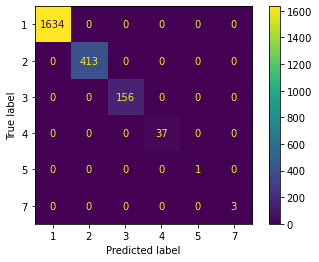

In [50]:
# Plot confusion matrix
fig = plot_confusion_matrix(rf_model, X_test, rf_y_pred)

In [ ]:
# List feature sorted in descending order by feature importance - is this needed?
#sorted(zip(rf_model.feature_importances_, X.columns), reverse = True)

In [51]:
# Random Forest model prediction
print(rf_y_pred)

[1 2 2 ... 1 2 2]


In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2],
    'max_leaf_nodes': [5],
    'n_estimators': [200],
    'oob_score': [True],
    'random_state': [0],
    'max_samples': [10],
    'max_features': [10],
    'min_samples_split': [50]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
# Fit the grid search to the data
grid_search.fit(X_train, y_train);
grid_search.best_params_
best_grid = grid_search.best_estimator_
pprint(best_grid.get_params())
selector = RFE(rf_model, step=1, verbose=3)
selector = selector.fit(X_train, y_train)
print("Features sorted by their rank:")
pprint(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), X)))

## Decision Tree Model

In [52]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifier
clf = clf.fit(X_train, y_train)

# Predict response for test dataset
clf_y_pred = clf.predict(X_test)

In [53]:
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

In [54]:
y_test_np = np.array(y_test)
clf_y_pred_np = np.array(clf_y_pred)

In [55]:
y_test_np = y_test_np.reshape(-1, 1)
clf_y_pred_np = clf_y_pred_np.reshape(-1, 1)

In [56]:
# Calculate ROC accuracy score
multiclass_roc_auc_score(y_test, clf_y_pred)

0.5624890263168624

In [57]:
# Print classification report
print(classification_report(y_test, clf_y_pred))

              precision    recall  f1-score   support

           1       0.54      0.65      0.59       969
           2       0.45      0.38      0.41       593
           3       0.32      0.30      0.31       365
           4       0.22      0.20      0.21       229
           5       0.04      0.03      0.03        33
           6       0.13      0.05      0.07        42
           7       0.33      0.08      0.12        13

    accuracy                           0.45      2244
   macro avg       0.29      0.24      0.25      2244
weighted avg       0.43      0.45      0.44      2244



In [58]:
# Display confusion matrix
clf_cm = confusion_matrix(y_test, clf_y_pred)
clf_cm

array([[628, 146,  98,  81,  12,   4,   0],
       [219, 224,  92,  47,   6,   4,   1],
       [144,  79, 109,  26,   3,   3,   1],
       [117,  37,  28,  45,   2,   0,   0],
       [ 17,   6,   6,   2,   1,   1,   0],
       [ 23,   9,   3,   5,   0,   2,   0],
       [  6,   2,   2,   0,   1,   1,   1]], dtype=int64)

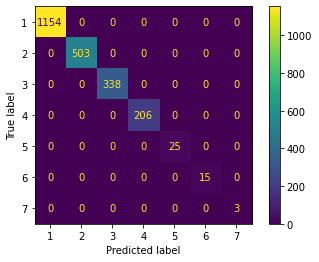

In [60]:
# Plot confusion matrix
fig = plot_confusion_matrix(clf, X_test, clf_y_pred)

In [61]:
# Decision Tree model prediction
print(clf_y_pred)

[1 2 2 ... 1 1 2]


In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2],
    'max_leaf_nodes': [5],
    'n_estimators': [200],
    'oob_score': [True],
    'random_state': [0],
    'max_samples': [10],
    'max_features': [10],
    'min_samples_split': [50]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
# Fit the grid search to the data
grid_search.fit(X_train, y_train);
grid_search.best_params_
best_grid = grid_search.best_estimator_
pprint(best_grid.get_params())
selector = RFE(rf_model, step=1, verbose=3)
selector = selector.fit(X_train, y_train)
print("Features sorted by their rank:")
pprint(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), X)))

## Logistic Regression Model

In [62]:
# Create logistic regression instance
logreg = LogisticRegression()

# Fit the model
logreg.fit(X_train, y_train)

# Predict response for test dataset
logreg_y_pred = logreg.predict(X_test)

In [63]:
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

In [64]:
y_test_np = np.array(y_test)
logreg_y_pred_np = np.array(logreg_y_pred)

In [65]:
y_test_np = y_test_np.reshape(-1, 1)
logreg_y_pred_np = logreg_y_pred_np.reshape(-1, 1)

In [66]:
# Calculate ROC accuracy score
multiclass_roc_auc_score(y_test, logreg_y_pred)

0.5063943603651481

In [67]:
# Print classification report
print(classification_report(y_test, logreg_y_pred))

              precision    recall  f1-score   support

           1       0.45      0.96      0.62       969
           2       0.29      0.09      0.14       593
           3       0.00      0.00      0.00       365
           4       0.00      0.00      0.00       229
           5       0.00      0.00      0.00        33
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        13

    accuracy                           0.44      2244
   macro avg       0.11      0.15      0.11      2244
weighted avg       0.27      0.44      0.30      2244



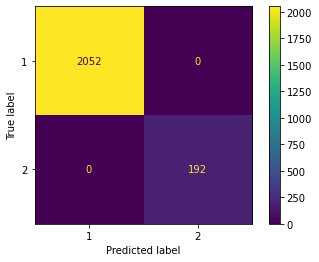

In [68]:
# Plot confusion matrix
fig = plot_confusion_matrix(logreg, X_test, logreg_y_pred)

In [69]:
# Print classification report
print(classification_report(y_test, logreg_y_pred))

              precision    recall  f1-score   support

           1       0.45      0.96      0.62       969
           2       0.29      0.09      0.14       593
           3       0.00      0.00      0.00       365
           4       0.00      0.00      0.00       229
           5       0.00      0.00      0.00        33
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        13

    accuracy                           0.44      2244
   macro avg       0.11      0.15      0.11      2244
weighted avg       0.27      0.44      0.30      2244



In [72]:
# Logistic Regression model prediction
print(logreg_y_pred)

[1 2 1 ... 1 1 2]


In [87]:
print(logreg.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [88]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [2],
    'max_leaf_nodes': [5],
    'n_estimators': [200],
    'oob_score': [True],
    'random_state': [0],
    'max_samples': [10],
    'max_features': [10],
    'min_samples_split': [50]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = logreg, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

start_time = time.time()

# Fit the grid search to the data
grid_search.fit(X_train, y_train);
grid_search.best_params_
best_grid = grid_search.best_estimator_
pprint(best_grid.get_params())
selector = RFE(logreg, step=1, verbose=3)
selector = selector.fit(X_train, y_train)
print("Features sorted by their rank:")
pprint(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), X)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: Invalid parameter max_features for estimator LogisticRegression(). Check the list of available parameters with `estimator.get_params().keys()`.

In [90]:
# Define grid of hyperparameter and apply grid search
# from https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)

lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X, y)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.466347 using {'C': 2.0, 'dual': False, 'max_iter': 130}
Execution time: 968.4952249526978 ms


In [91]:
random = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv = 3, n_jobs=-1)

start_time = time.time()
random_result = random.fit(X, y)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.464119 using {'max_iter': 110, 'dual': False, 'C': 1.0}
Execution time: 413.8016996383667 ms
